In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 8, 11, 41, 53, 814417)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-08 11:41:53,843 INFO: Initializing external client
2025-01-08 11:41:53,844 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 11:41:55,244 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-16 22:00:00+00:00,2.95,0.064256,0.0,0.0,7.928178,29183.220703,0.0,dublin,1,3,22
1,2025-01-14 08:00:00+00:00,7.50,4.387842,0.0,0.0,14.186923,28859.789062,0.0,dublin,1,1,8
2,2025-01-15 15:00:00+00:00,4.60,2.492247,0.0,0.0,2.902413,29019.097656,0.0,dublin,1,2,15
3,2025-01-12 03:00:00+00:00,2.90,0.436006,0.0,0.0,5.154416,28556.771484,0.0,dublin,1,6,3
4,2025-01-12 01:00:00+00:00,2.50,-0.174840,0.0,0.0,6.287130,28556.771484,0.0,dublin,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
222,2025-01-12 02:00:00+00:00,2.70,0.071427,0.0,0.0,6.214563,28556.771484,0.0,dublin,1,6,2
223,2025-01-12 21:00:00+00:00,8.95,6.122293,0.0,0.0,15.328561,28556.771484,0.0,dublin,1,6,21
224,2025-01-09 19:00:00+00:00,-2.05,-5.554811,0.0,0.0,6.924738,28145.916016,0.0,dublin,1,3,19
225,2025-01-16 13:00:00+00:00,6.80,4.694598,0.0,0.0,6.725354,29183.220703,0.0,dublin,1,3,13


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-16 22:00:00+00:00,2.95,0.064256,0.0,0.0,7.928178,29183.220703,0.0,dublin,1,3,22,39
1,2025-01-14 08:00:00+00:00,7.50,4.387842,0.0,0.0,14.186923,28859.789062,0.0,dublin,1,1,8,22
2,2025-01-15 15:00:00+00:00,4.60,2.492247,0.0,0.0,2.902413,29019.097656,0.0,dublin,1,2,15,5
3,2025-01-12 03:00:00+00:00,2.90,0.436006,0.0,0.0,5.154416,28556.771484,0.0,dublin,1,6,3,38
4,2025-01-12 01:00:00+00:00,2.50,-0.174840,0.0,0.0,6.287130,28556.771484,0.0,dublin,1,6,1,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2025-01-12 02:00:00+00:00,2.70,0.071427,0.0,0.0,6.214563,28556.771484,0.0,dublin,1,6,2,37
223,2025-01-12 21:00:00+00:00,8.95,6.122293,0.0,0.0,15.328561,28556.771484,0.0,dublin,1,6,21,37
224,2025-01-09 19:00:00+00:00,-2.05,-5.554811,0.0,0.0,6.924738,28145.916016,0.0,dublin,1,3,19,41
225,2025-01-16 13:00:00+00:00,6.80,4.694598,0.0,0.0,6.725354,29183.220703,0.0,dublin,1,3,13,7


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
56,2025-01-08 13:00:00+00:00,2.45,-0.496084,0.0,0.0,6.696387,28021.865234,0.0,dublin,1,2,13,8,1
202,2025-01-08 14:00:00+00:00,2.55,-0.583035,0.0,0.0,8.089993,28021.865234,0.0,dublin,1,2,14,7,2
57,2025-01-08 15:00:00+00:00,2.45,-0.869299,0.0,0.0,9.255571,28021.865234,0.0,dublin,1,2,15,5,3
11,2025-01-08 16:00:00+00:00,1.95,-1.551504,0.0,0.0,9.957108,28021.865234,0.0,dublin,1,2,16,4,4
74,2025-01-08 17:00:00+00:00,1.25,-2.371491,0.0,0.0,10.041354,28021.865234,0.0,dublin,1,2,17,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2025-01-17 19:00:00+00:00,5.05,1.534287,0.0,0.0,14.578890,29351.843750,0.0,dublin,1,4,19,34,223
171,2025-01-17 20:00:00+00:00,4.85,1.368568,0.0,0.0,14.277983,29351.843750,0.0,dublin,1,4,20,34,224
127,2025-01-17 21:00:00+00:00,4.60,1.185653,0.0,0.0,13.479583,29351.843750,0.0,dublin,1,4,21,34,225
67,2025-01-17 22:00:00+00:00,4.30,0.943740,0.0,0.0,12.682018,29351.843750,0.0,dublin,1,4,22,34,226


## Create forecast graph

2025-01-08 11:42:05,242 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



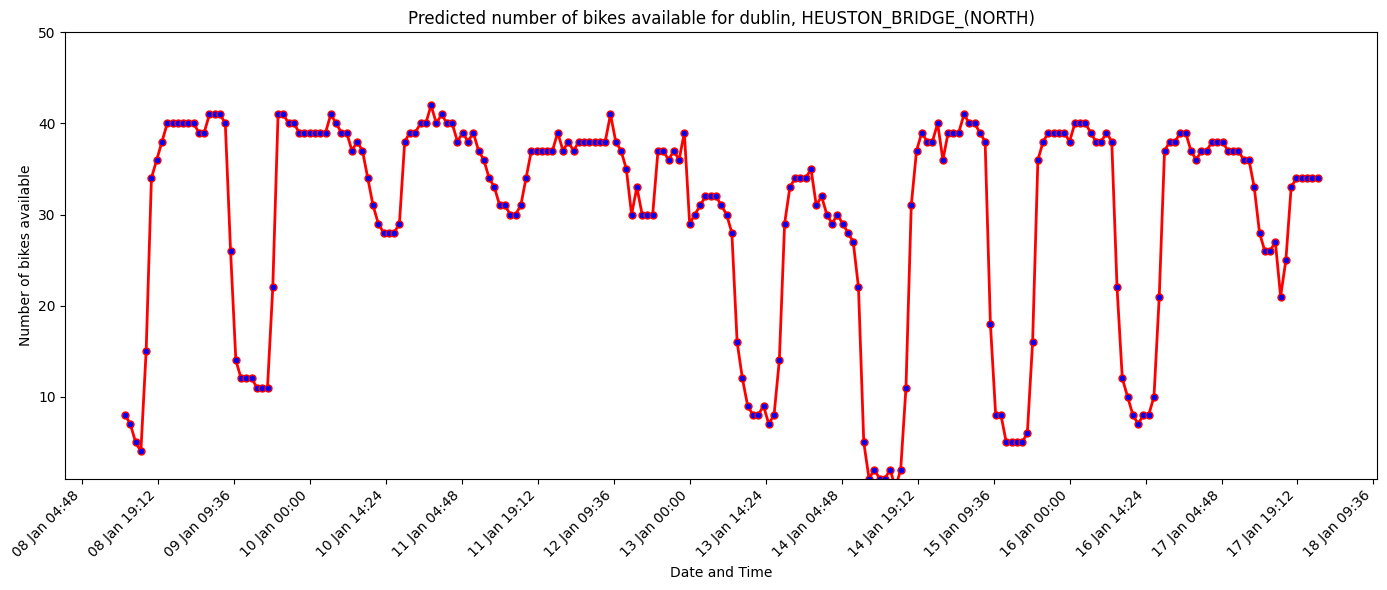

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 227/227 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-08 11:42:20,324 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-08 11:42:23,503 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-08 11:44:04,897 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-08 11:44:05,047 INFO: Waiting for log aggregation to finish.
2025-01-08 11:44:13,606 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [15]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time >= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.29s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-17 22:00:00+00:00,4.30,0.943740,0.0,0.0,12.682018,29351.843750,0.00,dublin,1,4,22,34,226
1,2025-01-16 03:00:00+00:00,-0.75,-3.331439,0.0,0.0,1.800000,29183.220703,0.00,dublin,1,3,3,40,183
2,2025-01-10 13:00:00+00:00,4.85,0.778039,0.0,0.0,13.183080,28276.632812,0.05,dublin,1,4,13,29,49
3,2025-01-10 19:00:00+00:00,4.70,0.364778,0.0,0.0,15.856354,28276.632812,0.05,dublin,1,4,19,39,55
4,2025-01-11 15:00:00+00:00,7.45,5.090454,0.0,0.0,10.182337,28413.685547,1.00,dublin,1,5,15,30,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2025-01-11 21:00:00+00:00,2.95,-0.534533,0.0,0.0,12.574260,28413.685547,1.00,dublin,1,5,21,37,81
200,2025-01-15 18:00:00+00:00,2.95,0.698365,0.0,0.0,3.219938,29019.097656,0.00,dublin,1,2,18,36,174
201,2025-01-12 18:00:00+00:00,8.30,5.645889,0.0,0.0,13.320000,28556.771484,0.00,dublin,1,6,18,37,102
202,2025-01-12 13:00:00+00:00,5.60,3.069518,0.0,0.0,8.587338,28556.771484,0.00,dublin,1,6,13,30,97


In [16]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()
bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.78s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9260,2025-01-06 20:49:03+00:00,HEUSTON_BRIDGE_(NORTH),35.0
9261,2025-01-07 22:49:09+00:00,HEUSTON_BRIDGE_(NORTH),39.0
9262,2025-01-07 12:46:54+00:00,HEUSTON_BRIDGE_(NORTH),23.0
9263,2025-01-07 09:50:06+00:00,HEUSTON_BRIDGE_(NORTH),26.0


In [17]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.34s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
12667,2025-01-12 02:00:00+00:00,2.7000,0.071427,0.0,0.0,6.214563,28556.771484,0.0,dublin
12668,2025-01-12 21:00:00+00:00,8.9500,6.122293,0.0,0.0,15.328561,28556.771484,0.0,dublin
12669,2025-01-09 19:00:00+00:00,-2.0500,-5.554811,0.0,0.0,6.924738,28145.916016,0.0,dublin
12670,2025-01-16 13:00:00+00:00,6.8000,4.694598,0.0,0.0,6.725354,29183.220703,0.0,dublin


In [18]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [19]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.80s) 


Uploading Dataframe: 100.00% |██████████| Rows 240/240 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-08 11:44:46,190 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-08 11:44:49,357 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-08 11:46:31,086 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-08 11:46:31,237 INFO: Waiting for log aggregation to finish.
2025-01-08 11:46:39,811 INFO: Execution finished successfully.


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,num_bikes_available,predicted_bikes_available,hours_before_forecast_time
8982,2024-12-27 00:00:00+00:00,10.189500,8.283388,0.0,0.00,11.448055,27147.181641,0.000000,dublin,12,4,0,40.0,39,1
8022,2024-12-27 01:00:00+00:00,9.389501,7.616785,0.0,0.00,9.172938,27147.181641,0.000000,dublin,12,4,1,40.0,41,2
7514,2024-12-27 02:00:00+00:00,9.389501,7.355697,0.0,0.00,11.052058,27147.181641,0.000000,dublin,12,4,2,40.0,39,3
1467,2024-12-27 03:00:00+00:00,9.539500,7.382965,0.0,0.00,12.072083,27147.181641,0.000000,dublin,12,4,3,40.0,39,4
1594,2024-12-27 04:00:00+00:00,9.589500,7.427346,0.0,0.00,12.200230,27147.181641,0.000000,dublin,12,4,4,40.0,39,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,2025-01-05 19:00:00+00:00,1.989500,-3.460598,0.7,0.14,24.923338,27805.240234,14.599998,dublin,1,6,19,31.0,31,236
2921,2025-01-05 20:00:00+00:00,1.789500,-3.620688,0.5,0.21,24.412407,27805.240234,14.599998,dublin,1,6,20,31.0,31,237
386,2025-01-05 21:00:00+00:00,1.689500,-3.813852,0.4,0.28,24.933735,27805.240234,14.599998,dublin,1,6,21,31.0,32,238
3387,2025-01-05 22:00:00+00:00,1.939500,-3.524250,0.5,0.14,24.662626,27805.240234,14.599998,dublin,1,6,22,31.0,32,239


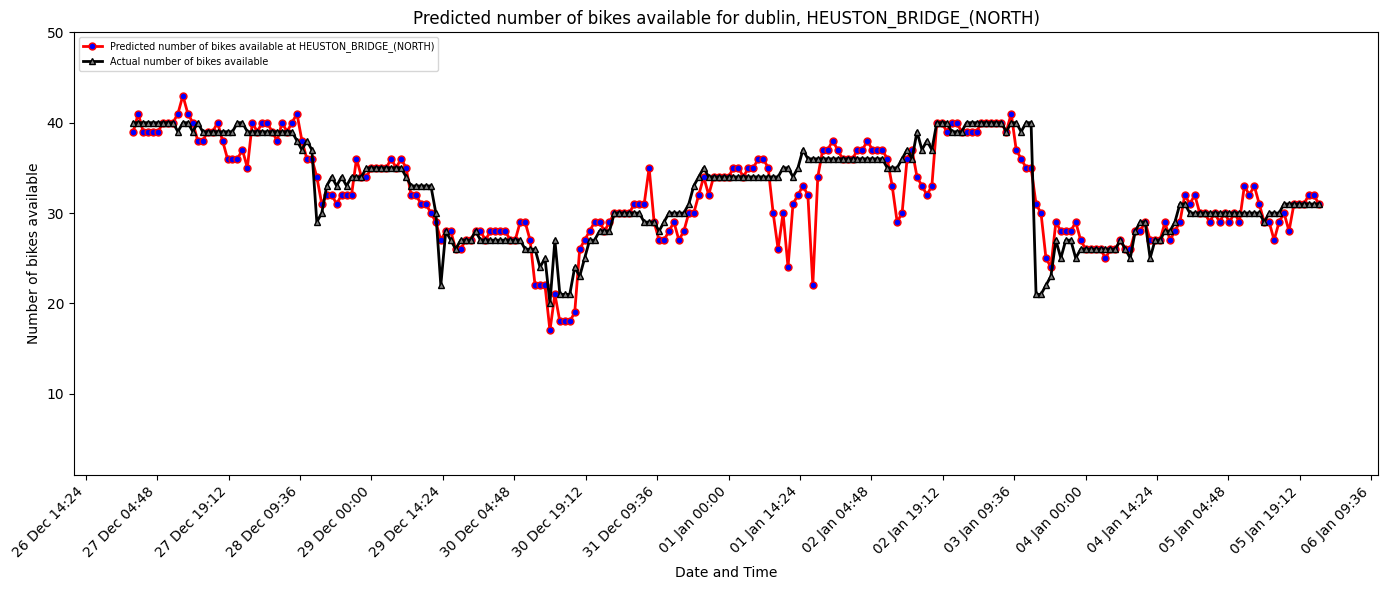

In [20]:
file_path = "docs/bike_availability_hindcast_1day.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df, file_path, hindcast=True)
plt.show()